In [1]:
import sys
import time

import random
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.hrnet_keras import HRNet
from models.hrnet_w40 import HRNet_W40
from models.u2net import U2NET

K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
# print(physical_devices,"\n")
# enable_amp() 

Tensorflow version:  2.4.1


In [2]:
# DATA_ROOT ="/home/jupyter/cityscapes_cv/"
# !gsutil cp -r gs://cityscapes_records_001 /home/jupyter/cityscapes_cv/

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [4]:
fine = True

if fine:
    train_tfrecord_dir = "records/trainIds_train.record"
    test_tfrecord_dir = "records/trainIds_val.record"
else:
    train_tfrecord_dir = "records/trainIds_train_extra.record"

img_height = 512
img_width = 1024
n_classes = 20

labels = get_labels()
trainId2label = { label.trainId : label for label in labels }
catId2label = { label.categoryId : label for label in labels }

In [5]:
@tf.function
def random_crop(image, mask):
    """
    Inputs: full resolution image and mask
    A scale between 0.5 and 1.0 is randomly chosen. 
    Then, we multiply original height and width by the scale, 
    and randomly crop to the scaled height and width.
    """
    scales = tf.range(0.5, 1.0, delta=0.01)
    scale = scales[tf.random.uniform(shape=[], minval=0, maxval=50, dtype=tf.int32)]
    shape = tf.cast(tf.shape(image), tf.float32)
    h = tf.cast(shape[0] * scale, tf.int32)
    w = tf.cast(shape[1] * scale, tf.int32)
    combined_tensor = tf.concat([image, mask], axis=2)
    combined_tensor = tf.image.random_crop(combined_tensor, size=[h, w, 4])
    return combined_tensor[:,:,0:3], combined_tensor[:,:,-1]
        

@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask)
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes)
    mask = tf.cast(mask, tf.float32)
    return image, mask


@tf.function
def load_image_train(input_image, input_mask):
    
    image = tf.cast(input_image, tf.uint8)
    mask = tf.cast(input_mask, tf.uint8)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
         
    if tf.random.uniform(()) > 0.5:
        image, mask = random_crop(image, mask)
        mask = tf.expand_dims(mask, axis=-1)
    
    image = tf.image.resize(image, (img_height, img_width))
    mask = tf.image.resize(mask, (img_height, img_width))
    
    image = tf.cast(image, tf.float32) / 255.0
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_saturation(image, 0.6, 1.6)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_hue(image, 0.05)
    
    image, mask = mask_to_categorical(image, mask)
    mask = tf.squeeze(mask)

    return image, mask


def load_image_test(input_image, input_mask):
    image = tf.image.resize(input_image, (img_height, img_width))
    mask = tf.image.resize(input_mask, (img_height, img_width))
    
    image = tf.cast(image, tf.float32) / 255.0
    image, mask = mask_to_categorical(image, mask)
    mask = tf.squeeze(mask)
    return image, mask


def load_image_eval(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    # input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)
    return input_image, input_mask


def load_image_train_no_aug(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)
    return input_image, input_mask

In [6]:
if fine:
    TRAIN_LENGTH = 2975
    TEST_LENGTH = 500
else:
    TRAIN_LENGTH = 18000
    TEST_LENGTH = 1998

BATCH_SIZE = 2
BUFFER_SIZE = 300

In [7]:
if fine:
    train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    test_ds = get_dataset_from_tfrecord(test_tfrecord_dir)
else:
    all_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    train_ds = all_ds.skip(TEST_LENGTH)
    test_ds = all_ds.take(TEST_LENGTH) 

In [8]:
# Preprocessing: random crop the images and masks, flip them
train = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(load_image_test)
eval = test_ds.map(load_image_eval)

In [9]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [38]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(0, n_classes):
        mask_rgb[mask[:,:,0]==i] = trainId2label[i].color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5), dpi=200)
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

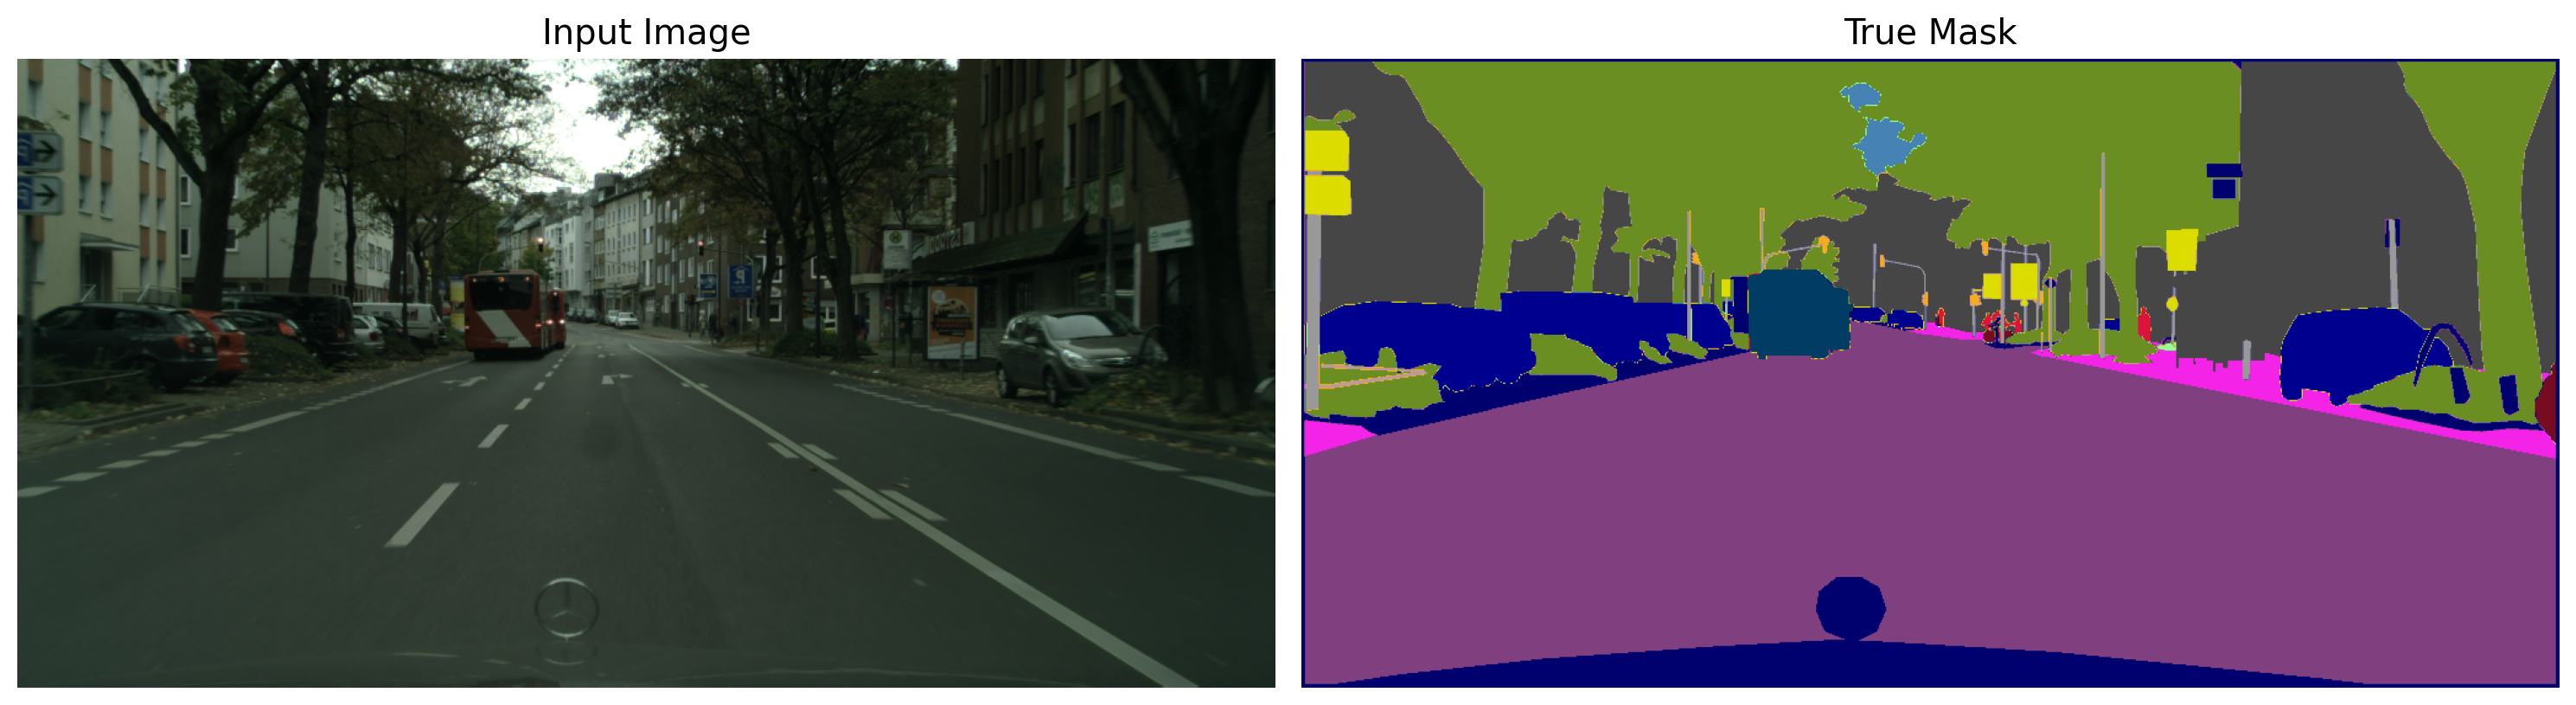

In [12]:
for image, mask in train.take(27): # 16
    sample_image, sample_mask = image, mask

sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [21]:
def iou_micro_coef(y_true, y_pred):
    """Gets the global IoU score (averaged over the batch) over all the classes at once"""
    smooth = 1.0
    A = y_true[:,:,:,1:]
    B = y_pred[:,:,:,1:]
    intersection = K.sum(A * B, axis=(1,2,3))
    union = K.sum(A, axis=(1,2,3)) + K.sum(B, axis=(1,2,3)) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_macro_coef(y_true, y_pred):
    """
    IOU = TP / (TP + FN + FP)
    Gets the IoU score for each class (averaged over the batch), then computes the mean
    When smooth=1, metrics where absent classes contribute to the class mean as 1.0
    """
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        tp = tf.math.reduce_sum(y_pred[:,:,:,i] * y_true[:,:,:,i], axis=(1,2))
        fn = tf.math.reduce_sum(y_true[:,:,:,i] * (1 - y_pred[:,:,:,i]), axis=(1,2)) 
        fp = tf.math.reduce_sum(y_pred[:,:,:,i] * (1 - y_true[:,:,:,i]), axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(tp+smooth, tp+fn+fp+smooth), axis=0)
        iou_total += iou

    iou_macro = iou_total / (n_classes - 1)
    return iou_macro


def iou_micro_loss(y_true, y_pred):
    return (1 - iou_micro_coef(y_true, y_pred)) 

def iou_macro_loss(y_true, y_pred):
    return (1 - iou_macro_coef(y_true, y_pred)) 

In [22]:
K.clear_session()
model = U2NET(input_height=img_height, input_width=img_width, n_classes=n_classes)
# model = Bisnet(input_height=img_height, input_width=img_width, n_classes=20)
# model = HRNet(input_height=img_height, input_width=img_width, n_classes=20, W=40)
# model = HRNet_W40(input_height=img_height, input_width=img_width, n_classes=20)
# model = ESNet(input_height=img_height, input_width=img_width, n_classes=20)

In [23]:
# plot_model(model, show_shapes=True, dpi=64)

In [24]:
# model.summary()

In [39]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions(eval_idx=None):
    if eval_idx is not None:
        for image, mask in eval.take(eval_idx): 
            sample_image, sample_mask = image, mask

        sample_mask = tf.argmax(sample_mask, axis=-1)
        sample_mask = sample_mask[..., tf.newaxis]
        sample_mask = label_to_rgb(sample_mask.numpy())
        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if model.name == "u2net":
        pred_mask = pred_mask[0]
    if eval_idx is not None:
        pred_mask = tf.image.resize(pred_mask, (1024, 2048))
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [26]:
if fine:
    MODEL_PATH = "weights/"+model.name+".h5"
else:
    MODEL_PATH = "weights/"+model.name+"_coarse.h5"

# model.load_weights(DATA_ROOT+"weights/"+model.name+"_coarse.h5")
model.load_weights("weights/"+model.name+"_sgd.h5")

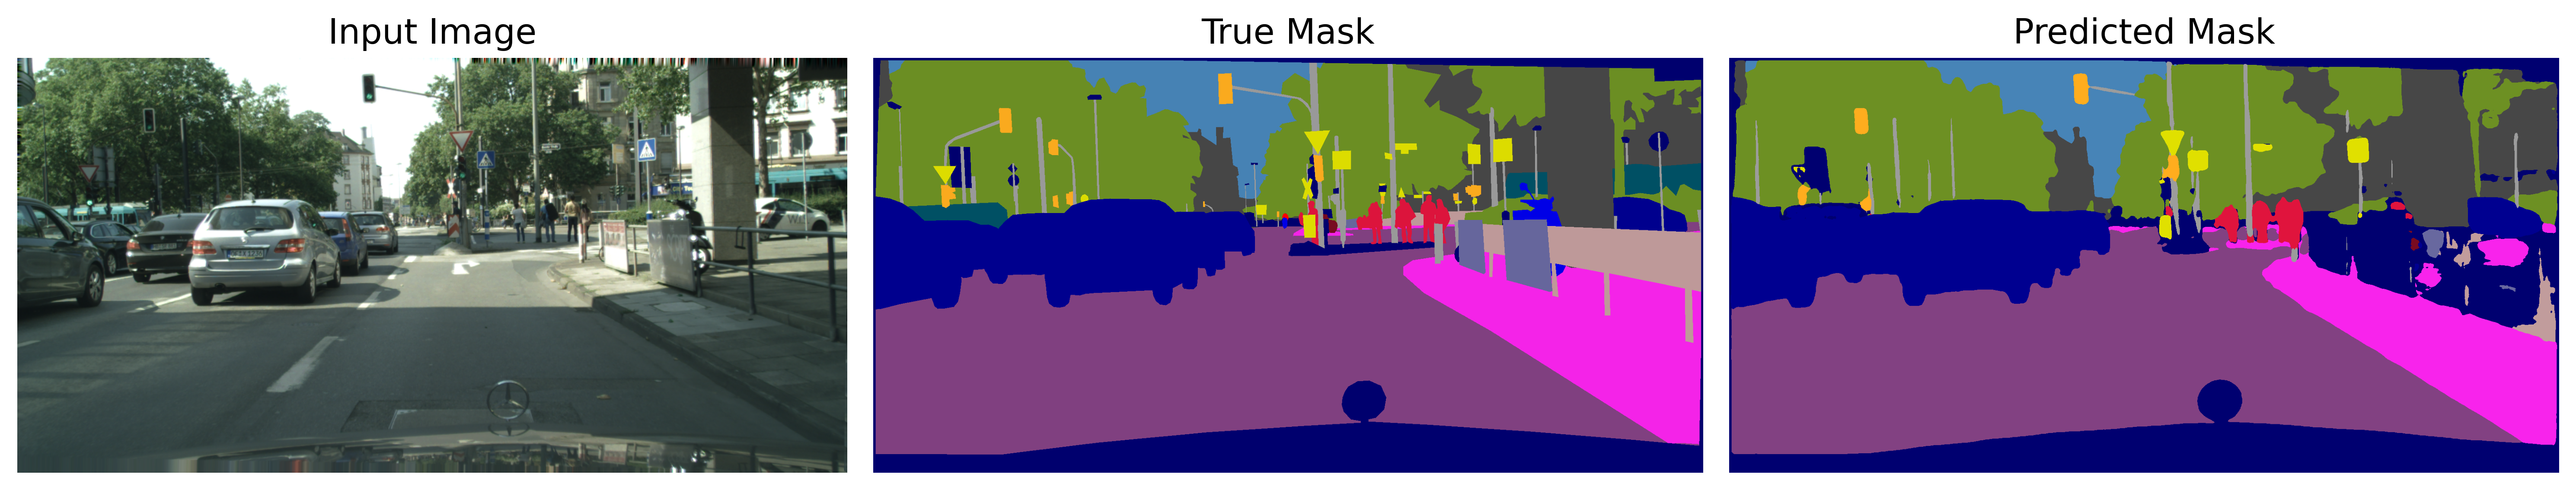

In [44]:
show_predictions(eval_idx=27)

In [ ]:
initial_lr = 0.01 
end_lr = 1e-5 
decay_steps = 120000 
learning_rate_fn = PolynomialDecay(
    initial_lr,
    decay_steps,
    end_lr,
    power=0.9
)

model.compile(
    optimizer = Adam(lr=1e-4), # SGD(learning_rate=learning_rate_fn, momentum=0.9),
    loss = iou_loss, 
    metrics = ['accuracy', iou_macro_coef]
)

In [ ]:
if fine:
    SUBSPLITS = 1
    EPOCHS = 150
    ES_patience = 8
    RLR_patience = 4
else:
    SUBSPLITS = 1
    ES_patience = 3
    RLR_patience = 1
    EPOCHS = 40

In [ ]:
callbacks = [
    DisplayCallback(),
    ModelCheckpoint(MODEL_PATH, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', mode='min', patience=ES_patience, verbose=1),
    # ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLR_patience, factor=0.1, min_lr=1e-10, verbose=1),
]

In [ ]:
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE // SUBSPLITS
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // SUBSPLITS

In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs = (EPOCHS*SUBSPLITS),
    validation_data = test_dataset,
    callbacks = callbacks,
    verbose = 1
)

In [ ]:
def plot_history(results, model):
        
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  
    if model.name == "u2net":
        plt.plot(results.history['d0_loss'], 'r', label='Training loss')
        plt.plot(results.history['val_d0_loss'], 'b', label='Validation loss')
    else: 
        plt.plot(results.history['loss'], 'r', label='Training loss')
        plt.plot(results.history['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    if model.name == "u2net":
        plt.plot(results.history['d0_accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_d0_accuracy'], 'b', label='Validation accuracy')
    else:
        plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
        plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    if model.name == "u2net":
        plt.plot(results.history['d0_iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_d0_iou_coef'], 'b', label='Validation IoU coefficient')
    else:
        plt.plot(results.history['iou_coef'], 'r', label='IoU coefficient')
        plt.plot(results.history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig(DATA_ROOT+"plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig(DATA_ROOT+"plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

In [ ]:
plot_history(results, model)

### Evaluation

For evaluation IoU scores, we need to calculate the *hard* IoU score as opposed to the *soft* IoU score. We used soft IoU function for training loss. Also, we want to resize everything to the original resolution. 

See this [link](https://www.jeremyjordan.me/semantic-segmentation/)


Variations of mean IoU score
- micro: True positives, false positives, and false negatives are computed globally
- macro: True positives, false positives, and false negatives are computed for each class and their unweighted mean is returned
- weighted: Metrics are computed for each class and returns the mean weighted by the number of true instances in each class 

In [46]:
def get_mean_iou(y_true, y_pred):
    """IOU = TP / (TP + FN + FP)"""
    y_pred = tf.image.resize(y_pred, (1024, 2048))
    
    threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
    # make sure [0, 0, 0] doesn't become [1, 1, 1]
    # Use abs(x) > eps, instead of x != 0 to check for zero
    y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    TP = tf.math.reduce_sum(y_pred[:,:,:,1:] * y_true[:,:,:,1:])
    FN = tf.math.reduce_sum(y_true[:,:,:,1:] * (1 - y_pred[:,:,:,1:])) 
    FP = tf.math.reduce_sum(y_pred[:,:,:,1:] * (1 - y_true[:,:,:,1:]))
    
    mean_iou_micro =  tf.math.divide_no_nan(TP, TP + FN + FP)

    smooth = 1
    iou_class = []
    for i in range(1, n_classes):
        tp = tf.math.reduce_sum(y_pred[:,:,:,i] * y_true[:,:,:,i])
        fn = tf.math.reduce_sum(y_true[:,:,:,i] * (1 - y_pred[:,:,:,i])) 
        fp = tf.math.reduce_sum(y_pred[:,:,:,i] * (1 - y_true[:,:,:,i])) 
        iou = tf.math.divide_no_nan(tp+smooth, tp+fn+fp+smooth)
        iou_class.append(iou)

    mean_iou_macro = np.mean(iou_class)

    return iou_class, mean_iou_micro.numpy(), mean_iou_macro


def evaluate_iou(model, dataset, n_samples):
    
    iou_class_scores = np.zeros((n_samples, n_classes-1))
    iou_micro_scores = np.zeros((n_samples,))
    iou_macro_scores = np.zeros((n_samples,))
    inf_times = np.zeros((n_samples, ))
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time.time()
        y_pred = model.predict(X)
        t_end = time.time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if model.name == "u2net":
            y_pred = y_pred[0]
        
        iou_class, iou_micro, iou_macro = get_mean_iou(y_true, y_pred)
        iou_class_scores[idx] = iou_class
        iou_micro_scores[idx] = iou_micro
        iou_macro_scores[idx] = iou_macro
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return np.mean(iou_class_scores, axis=0), np.mean(iou_micro_scores), np.mean(iou_macro_scores)

In [47]:
# iou_class, iou_mean_micro, iou_mean_macro = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_class, iou_mean_micro, iou_mean_macro = evaluate_iou(model=model, dataset=eval, n_samples=50)

 Predicting 50 \ 50 Average inference time: 3.45s


In [ ]:
print("IoU Score Micro: {:.4f}".format(iou_mean_micro))
print("IoU Score Macro: {:.4f}".format(iou_mean_macro))

In [ ]:
def plot_iou_trainId(trainId_label_map, catId_label_map, n_classes, iou_class, model, iou_mean, current_dir):

    categories = [trainId_label_map[i].category for i in range(1, n_classes)]
    
    cat_colors = {
        'void': colors.to_hex(list(np.array(catId_label_map[0].color)/255)),
        'flat': colors.to_hex(list(np.array(catId_label_map[1].color)/255)),
        'construction': colors.to_hex(list(np.array(catId_label_map[2].color)/255)),
        'object': colors.to_hex(list(np.array(catId_label_map[3].color)/255)),
        'nature': colors.to_hex(list(np.array(catId_label_map[4].color)/255)),
        'sky': colors.to_hex(list(np.array(catId_label_map[5].color)/255)),
        'human': colors.to_hex(list(np.array(catId_label_map[6].color)/255)),
        'vehicle': colors.to_hex(list(np.array(catId_label_map[7].color)/255))
    }
    _colors = [cat_colors[category] for category in categories]

    names = [trainId_label_map[i].name for i in range(1, n_classes)]

    fig, ax = plt.subplots(figsize=(14,10))
    hbars = ax.barh(names, iou_class, color=_colors)
    
    ax.set_xlabel("IoU Coefficient: ", fontsize=18)
    ax.set_ylabel("Class Name", fontsize=18)
    ax.set_title("Class Scores for {} - Mean IoU: {:.3f}".format(model.name, iou_mean), fontsize=22)
    ax.set_xlim([0, 1])
    
    ax.bar_label(hbars, fmt="%.2f", padding=3, fontsize=16)
    
    plt.savefig(current_dir+"plots/"+model.name+"_class_iou_scores.png")
    plt.show()

In [ ]:
plot_iou_trainId(
    trainId_label_map=trainId2label,
    catId_label_map=catId2label, 
    n_classes=n_classes, 
    iou_class=iou_class, 
    model=model, 
    iou_mean=iou_mean_macro,
    current_dir=""
)